# Let's go!

In [8]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import networkx as nx
from matplotlib import pyplot as plt
import cv2
from tqdm import tqdm
import community as community_louvain
from sklearn.cluster import SpectralClustering, AgglomerativeClustering
from PIL import Image
import pycolmap

In [34]:
# Paths
DATA_DIR = Path().cwd().parent / 'data'
TRAIN_DIR = DATA_DIR / 'train'
OUTPUT_DIR = Path().cwd().parent / 'output'

In [56]:
train_labels = pd.read_csv(DATA_DIR / 'train_labels.csv')

## Utility functions

In [35]:
# Load image file names from a dataset
def get_image_paths(data_dir):
    return sorted(f for f in data_dir.glob('*.png'))

**What it does:** retrieves a list of all png files within the data directory of choice and sorts them

In [1]:
# Extract features from image paths
def extract_features(image_paths, method='ORB', max_features=1000):
    if method == 'SIFT':
        detector = cv2.SIFT_create(nfeatures=max_features)
    elif method == 'AKAZE':
        detector = cv2.AKAZE_create()
    else:
        detector = cv2.ORB_create(nfeatures=max_features)
    features = {}

    # Iterate over image paths and extract features
    for img_path in tqdm(image_paths, desc=f'Extracting {method} features'):
        # Read image and convert to grayscale
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)

        # Skip if the image is not loaded
        if img is None: continue

        # Detect keypoints and compute descriptors
        kp, des = detector.detectAndCompute(img, None)
        features[img_path.name] = {
            'keypoints': kp,
            'descriptors': des
        }
    
    return features

**What it does:**
- Takes an array of image paths, a detector algorithm selection, and the max number of features
- Detects keypoints with the chosen algorithm
- Iterates over all images, loads them in and converts to greyscale, and computes descriptors around the keypoints
- Returns a dictionary containing the keypoints and descriptors for all images given to the function

In [37]:
# Matching features between two images using KNN
def match_features_knn(des1, des2, ratio=0.75):
    # Create BFMatcher with KNN
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    # Find matches using KNN
    matches = bf.knnMatch(des1, des2, k=2)
    # Iterate over matches and apply Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good_matches.append(m)
    return good_matches

**What it does:**
- Receives descriptors from two different images
- Exhaustively compares every descriptor in image 1 to every descriptor in image 2
- Uses Lowe's ratio to determine which matches are actually good

In [2]:
def geometric_verification_fundamental(kp1, kp2, matches, ransac_thresh=1.0):
    """
    Given two sets of keypoints and a list of matches, 
    first run fundamental-matrix RANSAC; if it fails or too few inliers,
    fall back on homography RANSAC.
    Returns only the inlier matches.
    """
    if len(matches) < 8:
        return []

    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

    # Try fundamental matrix first
    F, maskF = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, ransac_thresh, 0.99)
    inliersF = []
    if maskF is not None:
        inliersF = [matches[i] for i in range(len(matches)) if maskF[i]]

    # If fundamental yields few inliers, try homography
    if len(inliersF) < max(8, len(matches) * 0.5):
        H, maskH = cv2.findHomography(pts1, pts2, cv2.RANSAC, ransac_thresh)
        inliersH = []
        if maskH is not None:
            inliersH = [matches[i] for i in range(len(matches)) if maskH[i]]
        return inliersH

    return inliersF

**What it does:**
- Takes the keypoints from two images, as well as the matches between the same two images
- does something

In [ ]:
# Build graph from matched features using quality as edge weight
def build_image_graph_with_quality(features, min_matches=15, ratio_thresh=0.75):
    # Create networkx graph
    G = nx.Graph()
    # List of all image names
    image_names = list(features.keys())
    # Iterate over all images i
    for i in tqdm(range(len(image_names)), desc="Building image graph"):
        img_i = image_names[i]
        # Find descriptors for image i
        des_i = features[img_i]['descriptors']

        # If descriptors are not found, skip image
        if des_i is None: continue

        # Iterate over remaining images j
        for j in range(i+1, len(image_names)):
            img_j = image_names[j]    
            # Find descriptors for image j
            des_j = features[img_j]['descriptors']

            # If descriptors are not found, skip image
            if des_j is None: continue

            # Find good matches between i and j descriptors
            good_matches = match_features_knn(des_i, des_j, ratio=ratio_thresh)
            # If length of good matches is greater than min_matches add edge to graph
            if len(good_matches) >= min_matches:
                G.add_edge(img_i, img_j, weight=len(good_matches))

    # Add all nodes to graph
    for name in image_names:
        G.add_node(name)

    # Return the graph
    return G

# Build graph from matched features using geometric verification
def build_image_graph_with_geom(features, min_inliers=10, ratio_thresh=0.75, ransac_thresh=5.0):
    # Create graph
    G = nx.Graph()
    # List of all image names
    image_names = list(features.keys())
    for i in tqdm(range(len(image_names)), desc="Building image graph with geometric verification"):
        img_i = image_names[i]
        # Get descriptors and keypoints for image i
        des_i = features[img_i]['descriptors']
        kp_i = features[img_i]['keypoints']
        if des_i is None: continue

        for j in range(i+1, len(image_names)):
            img_j = image_names[j]
            # Get descriptors and keypoints for image j
            des_j = features[img_j]['descriptors']
            kp_j = features[img_j]['keypoints']
            if des_j is None: continue

            # Match features using KNN
            good_matches = match_features_knn(des_i, des_j, ratio=ratio_thresh)
            # Apply geometric verification
            inliers = geometric_verification_fundamental(
                kp_i,
                kp_j,
                good_matches,
                ransac_thresh=ransac_thresh
            )
            if len(inliers) >= min_inliers:
                G.add_edge(img_i, img_j, weight=len(inliers))
    
    # Add all nodes to graph
    for name in image_names:
        G.add_node(name)
    
    return G

**What it does:**
- Iterates over all images to find good matches between them.
- When a good match is found between two images, an edge is drawn between the two image nodes, with the weight of the edge being the number of good matches.
- This creates an undirecte weighted graph with two connected images being from the same scene and the weight being the evidence.

In [5]:
# Visualize matches between pairs of images
def show_images(img1, img2, kp1, kp2, matches, max_matches=30):
    # Draw matches
    img_matches = cv2.drawMatches(
        img1, 
        kp1, 
        img2, 
        kp2, 
        matches[:max_matches], 
        None, 
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    plt.figure(figsize=(12, 6))
    plt.imshow(img_matches)
    plt.axis('off')
    plt.show()

# Visualize the image graph
def plot_graph(graph):
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(graph, seed=42)
    nx.draw(graph, pos, with_labels=True, node_color='skyblue', node_size=400)
    plt.title("Image Similarity Graph")
    plt.show()


def show_cluster_samples(dataset_dir, clusters, samples_per_cluster=4):
    cols = samples_per_cluster
    for idx, cluster in enumerate(clusters):
        plt.figure(figsize=(cols*2,2))
        for i, img_name in enumerate(cluster[:samples_per_cluster]):
            img = Image.open(dataset_dir / img_name)
            plt.subplot(1, cols, i+1)
            plt.imshow(img)
            plt.axis('off')
        plt.suptitle(f"Cluster {idx+1} (size {len(cluster)})")
        plt.show()


**What it does:** Draws the undirected graph of image nodes

In [ ]:
# Simple clustering of images based on connected components in the graph
def cluster_images(graph):
    # Each connected component = a cluster/scene
    clusters = []
    for component in nx.connected_components(graph):
        clusters.append(list(component))
    return clusters

# Graph community detection using Louvain method
def cluster_louvain(graph):
    partition = community_louvain.best_partition(graph, weight='weight')
    clusters = {}
    for node, cluster_id in partition.items():
        clusters.setdefault(cluster_id, []).append(node)

    # Convert clusters to a list of lists
    clusters = list(clusters.values())
    return clusters

# Spectral clustering of images based on the graph Laplacian
def cluster_spectral(graph, n_clusters=None):
    # n_clusters: can use len(nx.connected_components(graph)) or specify a number
    adj_matrix = nx.to_numpy_array(graph)
    if n_clusters is None:
        n_clusters = len(nx.connected_components(graph))
    sc = SpectralClustering(
        n_clusters=n_clusters,
        affinity='precomputed',
        random_state=42
    )
    labels = sc.fitPredict(adj_matrix)
    image_names = list(graph.nodes())
    clusters = {}
    for idx, label in enumerate(labels):
        clusters.setdefault(label, []).append(image_names[idx])
    # Convert clusters to a list of lists
    clusters = list(clusters.values())
    return clusters

def cluster_agglomerative(graph, n_clusters=None, linkage='average'):
    """
    Convert graph to distance matrix (1 / weight), then run Agglomerative clustering.
    """
    nodes = list(graph.nodes())
    N = len(nodes)
    # Build distance matrix
    D = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if graph.has_edge(nodes[i], nodes[j]):
                w = graph[nodes[i]][nodes[j]]['weight']
                D[i,j] = 1.0 / w
            else:
                D[i,j] = np.inf
    # Estimate n_clusters if not given
    if n_clusters is None:
        n_clusters = len(list(nx.connected_components(graph)))
    model = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed',
                                    linkage=linkage)
    labels = model.fit_predict(D)
    clusters = {}
    for idx, lbl in enumerate(labels):
        clusters.setdefault(lbl, []).append(nodes[idx])
    return list(clusters.values())

**What it does:**
- Groups the images into scenes
- cluster_images uses connected components (pure topology), meaning any images reachable by a path of edges are grouped.
- cluster_luovain greedily merges nodes to maximise modularity. Works when scenes overlap slightly but still have higher internal connectivity.
- cluster_spectral cuts weak links even inside connected components by looking at eigenvectors of L = D - A (degrees minus adjacency). Works when connected components overlap more frequently.

In [53]:
# Simple outlier detection
def find_outliers_simple(graph):
    # Outliers are nodes with no edges
    return [node for node, degree in dict(graph.degree()).items() if degree == 0]

# Handling outliers in clusters
def find_outliers(graph, min_degree=1, min_total_weight=20):
    outliers = []
    for node in graph.nodes:
        degree = graph.degree(node)
        total_weight = sum([graph[node][nbr]['weight'] for nbr in graph.neighbors(node)])
        if degree < min_degree or total_weight < min_total_weight:
            outliers.append(node)
    return outliers

**What it does:**
- Finds outliers within the graph
- find_outliers_simple classifies only nodes with no edges connecting them to other nodes as outliers
- find_outliers classifies all nodes with a degree less than min_degree or a sum of edge weights less than min_total_weight as outliers.

In [1]:
# Automating evaluation on training data
def evaluate_clustering(clusters, train_labels, dataset_name):
    image_to_gt_scene = dict(zip(train_labels['image'], train_labels['scene']))
    cluster_to_gt_counts = []
    for cluster in clusters:
        scenes = [image_to_gt_scene.get(img, "unknown") for img in cluster]
        counts = pd.Series(scenes).value_counts()
        cluster_to_gt_counts.append(counts)
    for idx, counts in enumerate(cluster_to_gt_counts):
        print(f'Cluster {idx+1} around truth scene counts:\n{counts}\n')

**What it does:** Counts amount of images within each cluster, highlighting cluster purity, and performance.

In [ ]:
# Shared intrinsic guess
def make_K(img_shape, f_scale=1.2):
    h, w = img_shape
    f = f_scale * max(h, w)
    return np.array(
        [
            [f, 0, w/2],
            [0, f, h/2],
            [0, 0, 1]
        ], 
        dtype=np.float64
    )

In [7]:
# Basic OpenCV implementation
def essential_pose(img1, img2, feats, K):
    """Returns R, t (unit-norm) and inlier mask between two images."""
    kp1, des1 = feats[img1]['keypoints'], feats[img1]['descriptors']
    kp2, des2 = feats[img2]['keypoints'], feats[img2]['descriptors']
    matches = match_features_knn(des1, des2)
    inl = geometric_verification_fundamental(kp1, kp2, matches)
    if len(inl) < 8:
        return None
    pts1 = np.float32([kp1[m.queryIdx].pt for m in inl])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in inl])
    E, _ = cv2.findEssentialMat(
        pts1, 
        pts2, 
        K, 
        method=cv2.RANSAC, 
        prob=0.999, 
        threshold=1.0
    )
    if E is None: return None
    _, R, t, _ = cv2.recoverPose(E, pts1, pts2, K)
    return R, t(np.linalg.norm(t))

In [ ]:
# Cluster-wise chaining
def estimate_cluster_poses_basic(cluster, feats, K):
    """Anchor first image to identity; BFS over graph edges to propagate pose."""
    ref = cluster[0]
    poses = {ref: (np.eye(3), np.zeros(3))}
    q = [ref]
    edges = {(min(a,b), max(a,b)): essential_pose(a,b,feats,K)
             for a in cluster for b in cluster if a<b}
    while q:
        cur = q.pop()
        Rc, tc = poses[cur]
        for other in cluster:
            if other in poses: continue
            key = (min(cur, other), max(cur, other))
            if edges[key] is None: continue
            R, t = edges[key]
            # direction depending on pair order
            if cur > other:  # we estimated pose from other->cur
                R = R.T
                t = -R @ t
            Rn, tn = R @ Rc, R @ tc + t
            poses[other] = (Rn, tn)
            q.append(other)
    return poses

In [9]:
def export_matches_to_colmap(cluster, feats, K, folder):
    # save images into folder/images, save matches into folder/matches.txt
    return None

# incremental mapping
recon = pycolmap.incremental_mapping(folder)
recon.export_model(folder/'sparse')

NameError: name 'folder' is not defined

In [43]:
# Submission function
def create_submission_csv(dataset_name, clusters, outliers, output_path):
    rows = []
    # Assign clusters
    for cluster_idx, images in enumerate(clusters):
        for img_name in images:
            if img_name in outliers: continue # Skip outliers

            # 3x3 rotation (9 vals) + translation (3 vals) all set to nan (update when I add pose estimation)
            rows.append({
                'dataset': dataset_name,
                'scene': f'cluster{cluster_idx+1}',
                'image': img_name,
                'rotation_matrix': ';'.join(['nan']*9),
                'translation_vector': ';'.join(['nan']*3)
            })

    # Add outliers
    for img_name in outliers:
        rows.append({
            'dataset': dataset_name,
            'scene': 'outliers',
            'image': img_name,
            'rotation_matrix': ';'.join(['nan']*9),
            'translation_vector': ';'.join(['nan']*3)
        })

    # Save as CSV
    df = pd.DataFrame(rows)
    df.to_csv(output_path, index=False)
    print(f'Submission saved to {output_path}')

# Atual Implementation

In [66]:
DATASET_NAME = 'fbk_vineyard'
DATASET_DIR = TRAIN_DIR / DATASET_NAME

In [67]:
image_paths = get_image_paths(DATASET_DIR)
print(f'Found {len(image_paths)} images in the {DATASET_NAME} dataset.')

Found 163 images in the fbk_vineyard dataset.


In [ ]:
features_orb = extract_features(image_paths, method='ORB', max_features=1000)
features_sift = extract_features(image_paths, method='SIFT', max_features=1000)
features_akaze = extract_features(image_paths, method='AKAZE', max_features=1000)

Extracting ORB features: 100%|██████████| 163/163 [00:02<00:00, 72.79it/s]


Building image graph: 100%|██████████| 163/163 [00:15<00:00, 10.85it/s]


Graph has 163 nodes and 87 edges.


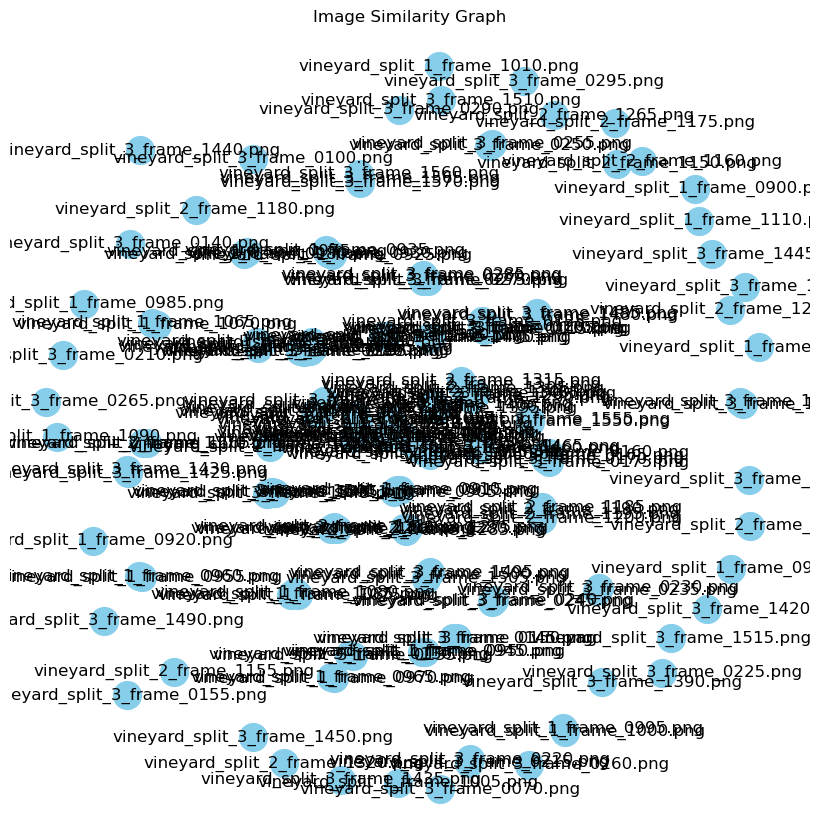

In [49]:
graph = build_image_graph_with_quality(features, min_matches=15, ratio_thresh=0.75)
print(f'Graph has {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.')
plot_graph(graph)

In [ ]:
clusters_simple = cluster_images(graph)
print(f'Found {len(clusters_simple)} clusters using connected components.')

clusters_louvain = cluster_louvain(graph)
print(f'Found {len(clusters_louvain)} clusters using Louvain method.')

cluster_spec = cluster_spectral(graph, n_clusters=len(clusters_louvain))
print(f'Found {len(cluster_spec)} clusters using Spectral Clustering.')

Found 79 clusters using connected components.
Found 79 clusters using Louvain method.


In [71]:
outliers_simple = find_outliers_simple(graph)
print(f'Found {len(outliers_simple)} outliers using simple method.')

outliers = find_outliers(graph, min_degree=1, min_total_weight=20)
print(f'Found {len(outliers)} outliers using advanced method.')

Found 39 outliers using simple method.
Found 64 outliers using advanced method.


In [74]:
for min_matches in [10, 15, 20]:
    for ratio_thresh in [0.7, 0.75, 0.8]:
        graph = build_image_graph_with_quality(features, min_matches=min_matches, ratio_thresh=ratio_thresh)
        clusters = cluster_louvain(graph)
        outliers = find_outliers(graph)
        print(f"min_matches={min_matches}, ratio_thresh={ratio_thresh}, clusters={len(clusters)}, outliers={len(outliers)}")
        evaluate_clustering(clusters, train_labels, DATASET_DIR.name)

Building image graph: 100%|██████████| 163/163 [00:14<00:00, 11.43it/s]


min_matches=10, ratio_thresh=0.7, clusters=98, outliers=119
Cluster 1 around truth scene counts:
vineyard_split_1    3
Name: count, dtype: int64

Cluster 2 around truth scene counts:
vineyard_split_1    2
Name: count, dtype: int64

Cluster 3 around truth scene counts:
vineyard_split_1    2
Name: count, dtype: int64

Cluster 4 around truth scene counts:
vineyard_split_1    2
Name: count, dtype: int64

Cluster 5 around truth scene counts:
vineyard_split_1    2
Name: count, dtype: int64

Cluster 6 around truth scene counts:
vineyard_split_1    2
Name: count, dtype: int64

Cluster 7 around truth scene counts:
vineyard_split_1    7
Name: count, dtype: int64

Cluster 8 around truth scene counts:
vineyard_split_1    3
Name: count, dtype: int64

Cluster 9 around truth scene counts:
vineyard_split_1    2
Name: count, dtype: int64

Cluster 10 around truth scene counts:
vineyard_split_1    3
Name: count, dtype: int64

Cluster 11 around truth scene counts:
vineyard_split_1    3
Name: count, dtype:

Building image graph: 100%|██████████| 163/163 [00:14<00:00, 11.64it/s]


min_matches=10, ratio_thresh=0.75, clusters=12, outliers=4
Cluster 1 around truth scene counts:
vineyard_split_3    14
vineyard_split_1     7
vineyard_split_2     6
Name: count, dtype: int64

Cluster 2 around truth scene counts:
vineyard_split_1    11
vineyard_split_2     1
vineyard_split_3     1
Name: count, dtype: int64

Cluster 3 around truth scene counts:
vineyard_split_2    6
vineyard_split_3    1
Name: count, dtype: int64

Cluster 4 around truth scene counts:
vineyard_split_2    7
vineyard_split_3    6
Name: count, dtype: int64

Cluster 5 around truth scene counts:
vineyard_split_3    15
vineyard_split_1     2
Name: count, dtype: int64

Cluster 6 around truth scene counts:
vineyard_split_3    11
vineyard_split_2     4
vineyard_split_1     1
Name: count, dtype: int64

Cluster 7 around truth scene counts:
vineyard_split_2    3
vineyard_split_1    2
vineyard_split_3    2
Name: count, dtype: int64

Cluster 8 around truth scene counts:
vineyard_split_1    8
vineyard_split_2    4
viney

Building image graph: 100%|██████████| 163/163 [00:14<00:00, 11.61it/s]


min_matches=10, ratio_thresh=0.8, clusters=7, outliers=0
Cluster 1 around truth scene counts:
vineyard_split_3    17
vineyard_split_2     6
vineyard_split_1     3
Name: count, dtype: int64

Cluster 2 around truth scene counts:
vineyard_split_3    18
vineyard_split_1    12
vineyard_split_2     5
Name: count, dtype: int64

Cluster 3 around truth scene counts:
vineyard_split_2    6
vineyard_split_3    6
vineyard_split_1    2
Name: count, dtype: int64

Cluster 4 around truth scene counts:
vineyard_split_3    15
vineyard_split_1    13
vineyard_split_2     8
Name: count, dtype: int64

Cluster 5 around truth scene counts:
vineyard_split_3    24
vineyard_split_1     6
vineyard_split_2     3
Name: count, dtype: int64

Cluster 6 around truth scene counts:
vineyard_split_1    7
vineyard_split_2    1
vineyard_split_3    1
Name: count, dtype: int64

Cluster 7 around truth scene counts:
vineyard_split_2    6
vineyard_split_3    4
Name: count, dtype: int64



Building image graph: 100%|██████████| 163/163 [00:14<00:00, 11.49it/s]


min_matches=15, ratio_thresh=0.7, clusters=125, outliers=129
Cluster 1 around truth scene counts:
vineyard_split_1    2
Name: count, dtype: int64

Cluster 2 around truth scene counts:
vineyard_split_1    2
Name: count, dtype: int64

Cluster 3 around truth scene counts:
vineyard_split_1    4
Name: count, dtype: int64

Cluster 4 around truth scene counts:
vineyard_split_1    2
Name: count, dtype: int64

Cluster 5 around truth scene counts:
vineyard_split_1    2
Name: count, dtype: int64

Cluster 6 around truth scene counts:
vineyard_split_1    3
Name: count, dtype: int64

Cluster 7 around truth scene counts:
vineyard_split_2    2
Name: count, dtype: int64

Cluster 8 around truth scene counts:
vineyard_split_2    2
Name: count, dtype: int64

Cluster 9 around truth scene counts:
vineyard_split_2    2
Name: count, dtype: int64

Cluster 10 around truth scene counts:
vineyard_split_2    2
Name: count, dtype: int64

Cluster 11 around truth scene counts:
vineyard_split_2    3
Name: count, dtype

Building image graph: 100%|██████████| 163/163 [00:13<00:00, 11.78it/s]


min_matches=15, ratio_thresh=0.75, clusters=79, outliers=64
Cluster 1 around truth scene counts:
vineyard_split_1    3
Name: count, dtype: int64

Cluster 2 around truth scene counts:
vineyard_split_1    3
Name: count, dtype: int64

Cluster 3 around truth scene counts:
vineyard_split_1    2
Name: count, dtype: int64

Cluster 4 around truth scene counts:
vineyard_split_1    2
Name: count, dtype: int64

Cluster 5 around truth scene counts:
vineyard_split_1    2
Name: count, dtype: int64

Cluster 6 around truth scene counts:
vineyard_split_1    2
Name: count, dtype: int64

Cluster 7 around truth scene counts:
vineyard_split_1    2
Name: count, dtype: int64

Cluster 8 around truth scene counts:
vineyard_split_1    10
vineyard_split_3     2
Name: count, dtype: int64

Cluster 9 around truth scene counts:
vineyard_split_1    2
Name: count, dtype: int64

Cluster 10 around truth scene counts:
vineyard_split_1    3
Name: count, dtype: int64

Cluster 11 around truth scene counts:
vineyard_split_1 

Building image graph: 100%|██████████| 163/163 [00:14<00:00, 11.51it/s]


min_matches=15, ratio_thresh=0.8, clusters=5, outliers=0
Cluster 1 around truth scene counts:
vineyard_split_3    24
vineyard_split_2    12
vineyard_split_1     7
Name: count, dtype: int64

Cluster 2 around truth scene counts:
vineyard_split_1    12
vineyard_split_3     2
vineyard_split_2     1
Name: count, dtype: int64

Cluster 3 around truth scene counts:
vineyard_split_3    17
vineyard_split_1    10
vineyard_split_2     4
Name: count, dtype: int64

Cluster 4 around truth scene counts:
vineyard_split_3    12
vineyard_split_2    10
vineyard_split_1     9
Name: count, dtype: int64

Cluster 5 around truth scene counts:
vineyard_split_3    30
vineyard_split_2     8
vineyard_split_1     5
Name: count, dtype: int64



Building image graph: 100%|██████████| 163/163 [00:14<00:00, 11.03it/s]


min_matches=20, ratio_thresh=0.7, clusters=146, outliers=132
Cluster 1 around truth scene counts:
vineyard_split_1    2
Name: count, dtype: int64

Cluster 2 around truth scene counts:
vineyard_split_1    3
Name: count, dtype: int64

Cluster 3 around truth scene counts:
vineyard_split_1    2
Name: count, dtype: int64

Cluster 4 around truth scene counts:
vineyard_split_2    2
Name: count, dtype: int64

Cluster 5 around truth scene counts:
vineyard_split_2    3
Name: count, dtype: int64

Cluster 6 around truth scene counts:
vineyard_split_3    2
Name: count, dtype: int64

Cluster 7 around truth scene counts:
vineyard_split_3    3
Name: count, dtype: int64

Cluster 8 around truth scene counts:
vineyard_split_3    2
Name: count, dtype: int64

Cluster 9 around truth scene counts:
vineyard_split_3    2
Name: count, dtype: int64

Cluster 10 around truth scene counts:
vineyard_split_3    2
Name: count, dtype: int64

Cluster 11 around truth scene counts:
vineyard_split_3    2
Name: count, dtype

Building image graph: 100%|██████████| 163/163 [00:14<00:00, 11.31it/s]


min_matches=20, ratio_thresh=0.75, clusters=104, outliers=66
Cluster 1 around truth scene counts:
vineyard_split_1    3
Name: count, dtype: int64

Cluster 2 around truth scene counts:
vineyard_split_1    3
Name: count, dtype: int64

Cluster 3 around truth scene counts:
vineyard_split_1    2
Name: count, dtype: int64

Cluster 4 around truth scene counts:
vineyard_split_1    2
Name: count, dtype: int64

Cluster 5 around truth scene counts:
vineyard_split_1    2
Name: count, dtype: int64

Cluster 6 around truth scene counts:
vineyard_split_1    2
Name: count, dtype: int64

Cluster 7 around truth scene counts:
vineyard_split_1    7
Name: count, dtype: int64

Cluster 8 around truth scene counts:
vineyard_split_1    2
Name: count, dtype: int64

Cluster 9 around truth scene counts:
vineyard_split_1    2
Name: count, dtype: int64

Cluster 10 around truth scene counts:
vineyard_split_1    3
Name: count, dtype: int64

Cluster 11 around truth scene counts:
vineyard_split_2    2
Name: count, dtype

Building image graph: 100%|██████████| 163/163 [00:13<00:00, 11.68it/s]


min_matches=20, ratio_thresh=0.8, clusters=7, outliers=0
Cluster 1 around truth scene counts:
vineyard_split_1    6
vineyard_split_3    6
vineyard_split_2    1
Name: count, dtype: int64

Cluster 2 around truth scene counts:
vineyard_split_3    10
vineyard_split_2     9
vineyard_split_1     7
Name: count, dtype: int64

Cluster 3 around truth scene counts:
vineyard_split_3    16
vineyard_split_1    10
vineyard_split_2     9
Name: count, dtype: int64

Cluster 4 around truth scene counts:
vineyard_split_1    3
vineyard_split_2    3
vineyard_split_3    2
Name: count, dtype: int64

Cluster 5 around truth scene counts:
vineyard_split_1    4
vineyard_split_2    3
vineyard_split_3    2
Name: count, dtype: int64

Cluster 6 around truth scene counts:
vineyard_split_3    25
vineyard_split_1    12
vineyard_split_2     5
Name: count, dtype: int64

Cluster 7 around truth scene counts:
vineyard_split_3    24
vineyard_split_2     5
vineyard_split_1     1
Name: count, dtype: int64



In [ ]:
output_csv = Path('./output/submission.csv')
create_submission_csv(DATASET_DIR.name, clusters_louvain, outliers, output_csv)
print(f"Submission written to {output_csv}")